### Obtain spectra for the sources and add additional spec-zs from SIMBAD

In [2]:
%matplotlib inline
import sys, os, glob, copy

from astropy.io import fits, ascii

import numpy as np
import matplotlib.pyplot as plt
from astropy import units as u
import astropy.constants as const
from astropy.coordinates import SkyCoord, concatenate
from astropy import table

In [3]:
import scienceplots

plt.style.use(['bright', 'science', 'no-latex', 'notebook'])

### Read the HSC-SSP AGN table:

https://ui.adsabs.harvard.edu/abs/2020ApJ...894...24K/abstract

In [4]:
# Read HSC-SSP AGNs
data_agn = ascii.read('hsc_agn.txt')
cat_agn = SkyCoord(data_agn['RAdeg'], data_agn['DEdeg'], unit='deg')
data_agn

ID,RAdeg,DEdeg,i-mag,X-flag,g-flag,r-flag,i-flag,z-flag,n-corr,z,r_z,ID-COSMOS2015
--,deg,deg,mag,--,--,--,--,--,--,--,--,--
int64,float64,float64,float64,int64,int64,int64,int64,int64,int64,float64,int64,int64
1,150.74386,2.20245,22.71,1,1,1,1,1,6,1.561,3,594392
2,150.73557,2.19957,20.36,1,1,1,1,1,6,3.499,1,592797
3,150.73353,2.15646,20.88,1,1,1,1,1,6,0.977,1,565402
4,150.79702,2.13888,21.01,1,1,1,1,1,6,0.573,1,552225
5,150.78259,2.19306,20.63,1,1,1,1,1,6,0.585,1,589540
6,150.72019,2.24803,21.13,1,1,1,1,1,6,0.664,1,625595
7,150.78838,2.34399,19.82,1,1,1,1,1,6,1.964,1,689768
8,150.71511,2.48483,19.2,1,1,1,1,1,6,1.999,1,782508


1: spectroscopic redshift from the HSC catalog,

2: spectroscopic redshift from the DEIMOS catalog,

3: photometric redshift from z_best in the Chandra catalog,

4: photometric redshift from ZPDF in the COSMOS2015 catalog.

There are still more with spectra than it appears th

### Match to SIMBAD

Field description refers to:  
https://github.com/astropy/astroquery/blob/main/astroquery/simbad/data/votable_fields_dict.json

In [353]:
mask_specz = data_agn['r_z'] < 3

print(len(data_agn[mask_specz]))

from astroquery.simbad import Simbad

# Add the redshift information
customSimbad = Simbad()
customSimbad.add_votable_fields('rvz_qual','rvz_wavelength','z_value', 'rvz_bibcode')

result_table = customSimbad.query_region(cat_agn, radius=0.5*u.arcsec)

# Sources with RVZ_WAVELENGTH == 'O' and rvz_qual!='E' should have an optical spectrum
print(len(result_table[result_table['RVZ_WAVELENGTH']=='O'])) 

mask_spec_simbad = (result_table['RVZ_WAVELENGTH']=='O') & (result_table['RVZ_QUAL']!='E') 

result_table.write('result_table.txt', format='csv', overwrite=True)

337
310


/home/chisen/anaconda3/envs/py39-wsl2/lib/python3.9/site-packages/astroquery/simbad/core.py:135: UserWarning: Warning: The script line number 89 raised an error (recorded in the `errors` attribute of the result table): '10:01:58.956 +2:24:45.216': No astronomical object found :  
  warnings.warn("Warning: The script line number %i raised "


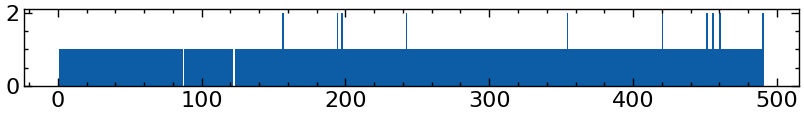

In [325]:
# check if almost each item has a return

plt.figure(figsize=[10, 1])
plt.h

In [14]:
unq, unq_idx, unq_cnt = np.unique(result_table['SCRIPT_NUMBER_ID'], return_inverse=True, return_counts=True)

# result_table['SCRIPT_NUMBER_ID'] #[unq_cnt>1]
len(unq_cnt)

### Add the new SIMBAD spec-z back into the table

0 = SIMBAD spec-z

In [331]:
idx = result_table['SCRIPT_NUMBER_ID'].data.data - 1
idx_simbad_specz = idx[mask_spec_simbad]

# prepare the updated table with extra columns
data_agn_updated = copy.deepcopy(data_agn)
data_agn_updated['bibcode'] = '-'*19
# refers to teh note in 'hsc_agn.txt': 
data_agn_updated['bibcode'][data_agn['r_z']==1] = '2020ApJ...894...24K'
data_agn_updated['bibcode'][data_agn['r_z']==2] = '2018ApJ...858...77H'

#for i in idx_simbad_specz:
for j,i in enumerate(idx_simbad_specz):
    # Update if no ex
    if data_agn_updated['r_z'][i] > 2:
        data_agn_updated['r_z'][i] = 0
        #data_agn_updated['r_z'][i] = result_table['Z_VALUE'][i]
        data_agn_updated['z'][i] = result_table[mask_spec_simbad]['Z_VALUE'][j]
        data_agn_updated['bibcode'][i] = result_table[mask_spec_simbad]['RVZ_BIBCODE'][j]
        data_agn_updated['bibcode'][i] = result_table[mask_spec_simbad]['RVZ_BIBCODE'][j]
        # data_agn_updated['name'][i] = result_table[mask_spec_simbad]['MAIN_ID'][j]
    # Check for incons

mask_specz_updated = data_agn_updated['r_z'] < 3
print(len(data_agn_updated[mask_specz_updated]))
mask_specz = data_agn['r_z'] < 3
print(len(data_agn[mask_specz]))

data_agn_updated.write('hsc_agn_updated.txt', format='ascii', overwrite=True)

sum(data_agn_updated['r_z']==2)

392
337


21

In [332]:
data_agn_updated

ID,RAdeg,DEdeg,i-mag,X-flag,g-flag,r-flag,i-flag,z-flag,n-corr,z,r_z,ID-COSMOS2015,bibcode
--,deg,deg,mag,--,--,--,--,--,--,--,--,--,
int64,float64,float64,float64,int64,int64,int64,int64,int64,int64,float64,int64,int64,str19
1,150.74386,2.20245,22.71,1,1,1,1,1,6,1.561,3,594392,-------------------
2,150.73557,2.19957,20.36,1,1,1,1,1,6,3.499,1,592797,2020ApJ...894...24K
3,150.73353,2.15646,20.88,1,1,1,1,1,6,0.977,1,565402,2020ApJ...894...24K
4,150.79702,2.13888,21.01,1,1,1,1,1,6,0.573,1,552225,2020ApJ...894...24K
5,150.78259,2.19306,20.63,1,1,1,1,1,6,0.585,1,589540,2020ApJ...894...24K
6,150.72019,2.24803,21.13,1,1,1,1,1,6,0.664,1,625595,2020ApJ...894...24K
7,150.78838,2.34399,19.82,1,1,1,1,1,6,1.964,1,689768,2020ApJ...894...24K
8,150.71511,2.48483,19.2,1,1,1,1,1,6,1.999,1,782508,2020ApJ...894...24K


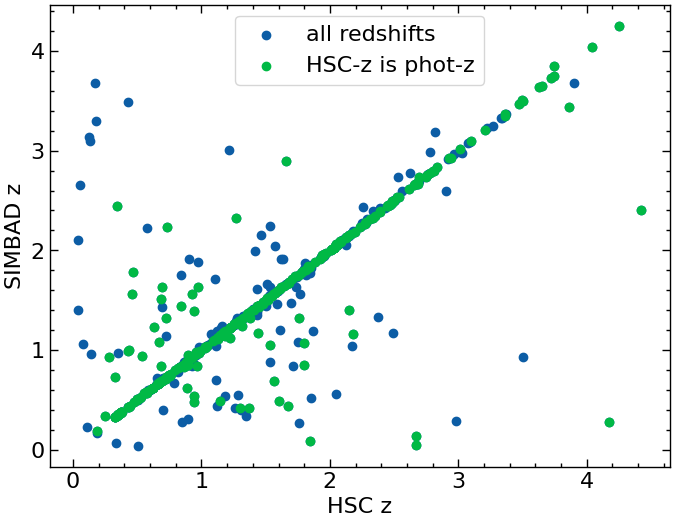

In [333]:
plt.scatter(result_table['Z_VALUE'], data_agn['z'][idx], label='all redshifts')#, c=result_table['SCRIPT_NUMBER_ID'])
plt.scatter(result_table['Z_VALUE'][mask_spec_simbad], data_agn['z'][idx][mask_spec_simbad], label='HSC-z 
plt.xlabel('HSC z')
plt.ylabel('SIMBAD z')
plt.legend(frameon=True)

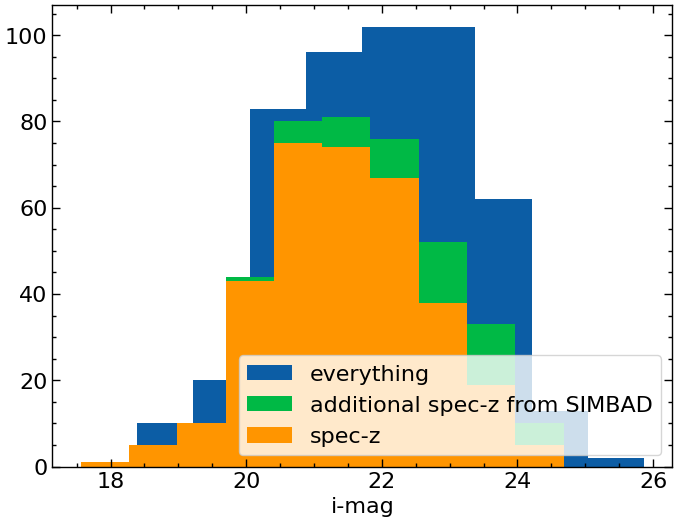

In [152]:
mask_specz_updated = data_agn_updated['r_z'] < 3
plt.h
plt.h
mask_specz = data_agn['r_z'] < 3
plt.h
plt.xlabel('i-mag')
plt.legend(frameon=True, loc=4)

### Manually inspect the incons

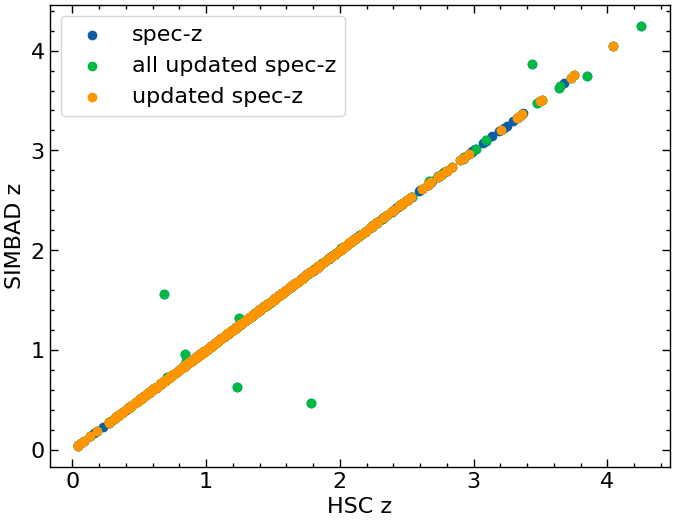

In [153]:
plt.scatter(data_agn['z'], data_agn_updated['z'], label='spec-z')
plt.scatter(data_agn['z'][mask_specz_updated], data_agn_updated['z'][mask_specz_updated], label='all updated spec-z')
plt.scatter(data_agn['z'][mask_specz & mask_specz_updated], data_agn_updated['z'][mask_specz & mask_specz_updated], label='updated spec-z')

Check if SIMBAD spec-z and paper spec-z are cons

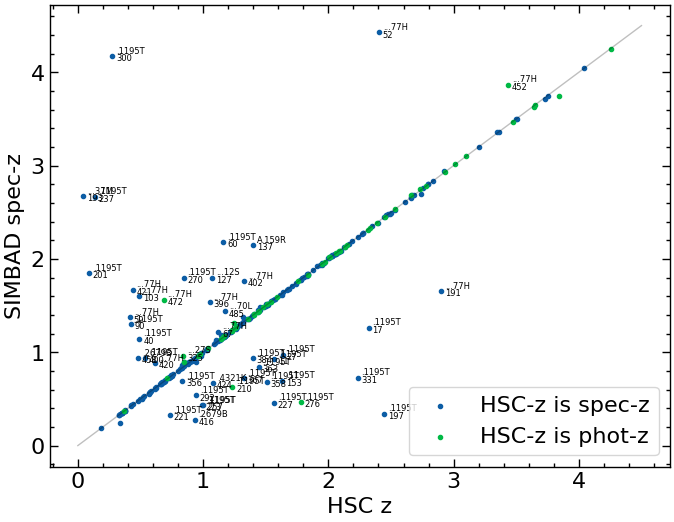

In [383]:
data_agn_compare = table.Table(data=[[0.]*491, ['none']*491, [0.]*491, ['-'*19]*491, [None]*491], 
                               names=['HSC-z', 'r_HSC-z', 'SIMBAD-z', 'bib_SIMBAD-z', 'name'])
for j,i in enumerate(idx_simbad_specz):
    if data_agn['r_z'][i] <= 2:
        data_agn_compare['r_HSC-z'][i] = 'spec'
    else: 
        data_agn_compare['r_HSC-z'][i] = 'phot'
    data_agn_compare['HSC-z'][i] = data_agn['z'][i]
    data_agn_compare['SIMBAD-z'][i] = result_table[mask_spec_simbad]['Z_VALUE'][j]
    data_agn_compare['bib_SIMBAD-z'][i] = result_table[mask_spec_simbad]['RVZ_BIBCODE'][j]
    data_agn_compare['name'][i] = result_table[mask_spec_simbad]['MAIN_ID'][j]


plt.scatter(data_agn_compare['HSC-z'][data_agn_compare['r_HSC-z']=='spec'], 
            data_agn_compare['SIMBAD-z'][data_agn_compare['r_HSC-z']=='spec'], 
            marker='.', label='HSC-z 
plt.scatter(data_agn_compare['HSC-z'][data_agn_compare['r_HSC-z']=='phot'], 
            data_agn_compare['SIMBAD-z'][data_agn_compare['r_HSC-z']=='phot'], 
            marker='.', label='HSC-z 
# plt.scatter(data_agn_compare['HSC-z'][(data_agn_compare['r_HSC-z']=='spec') & (data_agn_compare['bib_SIMBAD-z']=='2020AJ....160...37M')], 
#             data_agn_compare['SIMBAD-z'][(data_agn_compare['r_HSC-z']=='spec') & (data_agn_compare['bib_SIMBAD-z']=='2020AJ....160...37M')], 
#             marker='.', label='selected bibcode')
# add bibcode to those incons
for i, txt in enumerate(data_agn_compare['bib_SIMBAD-z']): #enumerate(np.arange(491)+1):
    if np.abs(data_agn_compare['HSC-z'][i] - data_agn_compare['SIMBAD-z'][i])>0.1: 
        plt.annotate(txt[13:], (data_agn_compare['HSC-z'][i]+0.03, data_agn_compare['SIMBAD-z'][i]+0.03), size=6)
        plt.annotate(i+1, (data_agn_compare['HSC-z'][i]+0.03, data_agn_compare['SIMBAD-z'][i]-0.05), size=6)
plt.plot([0, 4.5], [0, 4.5], '-k', linewidth=1, alpha=0.25)
plt.xlabel('HSC z')
plt.ylabel('SIMBAD spec-z')
plt.legend(frameon=True)
plt.show()

In [195]:
# check the bibcode of all comparable (has hsc spec-z) simbad spec-z
bib, cnt = np.unique(data_agn_compare['bib_SIMBAD-z'][data_agn_compare['r_HSC-z']=='spec'], return_counts=True)
table.Table([bib, cnt], names=['bibcode', 'count'])

bibcode,count
str19,int64
2007ApJS..172...70L,32
2009ApJ...693....8B,1
2009ApJ...696.1195T,159
2012ApJ...753..121K,1
2012ApJ...758...47A,1
2012ApJS..203...21A,1
2014A&A...563A..54P,4
2014MNRAS.443.2679B,3
2015ApJS..219...12A,4


### Make a table of where spectra come from 

In [91]:
# numher of spectra eventually using simbad, not used
id_simbad = data_agn_updated[data_agn_updated['r_z']==0]['ID']
len(id_simbad)
# mask_simbad_specz_simbad = np.

55

"`-------------------`" means photo-z

`2020ApJ...894...24K` and `2018ApJ...858...77H` refers to original catalogs

In [99]:
result_rvz_bib = data_agn_updated['bibcode']
bib, cnt = np.unique(result_rvz_bib, return_counts=True)
table.Table([bib, cnt], names=['bibcode', 'count'])

bibcode,count
str19,int64
-------------------,99
2007ApJS..172...70L,3
2007ApJS..172...99C,1
2009ApJ...696.1195T,36
2010AJ....140..533G,1
2011ApJ...742...61S,1
2012MNRAS.427.3103B,3
2014A&A...563A..54P,1
2015A&A...584A..62C,1


-------------------
2007ApJS..172...70L, 
2007ApJS..172...99C
2009ApJ...696.1195T, Magellean/zCOSMOS, https://irsa.ipac.caltech.edu/data/COSMOS/
2010AJ....140..533G
2011ApJ...742...61S
2012MNRAS.427.3103B
2014A&A...563A..54P
2015A&A...584A..62C
2015ApJ...806L..35K
2018ApJ...858...77H, DEIMOS, not publicly available
2018ApJS..234...21D
2019ApJS..244...40L
2020ApJ...894...24K, HSC, https://hsc-release.mtk.nao.ac.jp/doc/index.php/specz-2/


### Download the spectra

Show the objects in the sky

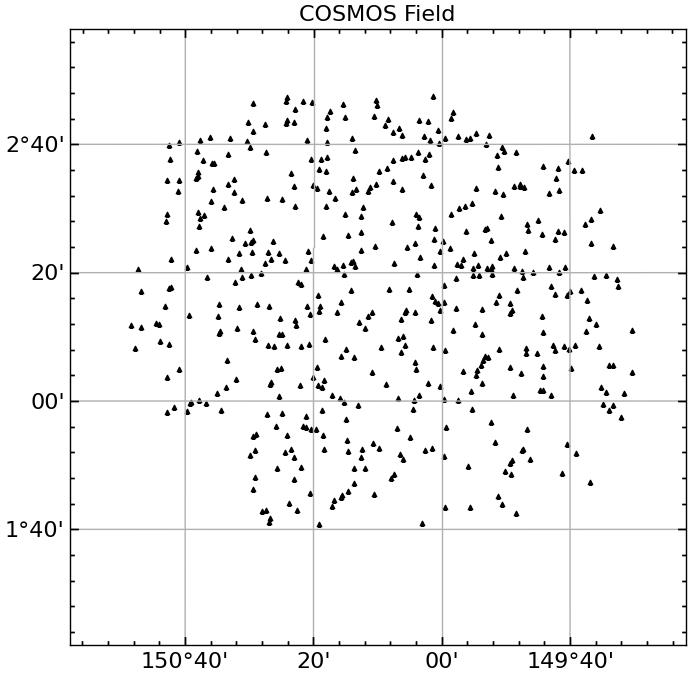

In [388]:
import ligo.skymap.plot

ra, dec = data_agn_updated['RAdeg'], data_agn_updated['DEdeg']

fig = plt.figure(figsize=[12, 8], dpi=100)
ax1 = plt.axes(projection='astro degrees zoom', center='150d10m 2d10m', radius='0.8 deg')

ax1.scatter(ra, dec, transform=ax1.get_transform('world'), s=10, marker='^', color='k', alpha=1, label='DES')

ax1.grid()
# ax1.set_ax
# ax1.coords['ra'].set_ticks_v
# ax1.coords['dec'].set_ticks_v
ax1.coords['ra'].set_auto_axislabel(False)
ax1.coords['dec'].set_auto_axislabel(False)

ax1.set_title('COSMOS Field')

plt.show()

In [214]:
data_agn_updated[data_agn_updated['bibcode']=='2009ApJ...696.1195T']

# result_table[result_table['RVZ_BIBCODE']=='2009ApJ...696.1195T']

ID,RAdeg,DEdeg,i-mag,X-flag,g-flag,r-flag,i-flag,z-flag,n-corr,z,r_z,ID-COSMOS2015,bibcode
--,deg,deg,mag,--,--,--,--,--,--,--,--,--,
int64,float64,float64,float64,int64,int64,int64,int64,int64,int64,float64,int64,int64,str19
13,150.68274,2.08403,20.72,1,1,1,1,1,5,1.2338,0,516177,2009ApJ...696.1195T
29,150.56727,2.50359,21.03,1,1,1,1,1,6,1.1461,0,794377,2009ApJ...696.1195T
30,150.61728,2.48275,22.59,1,1,1,1,1,6,2.7456,0,779775,2009ApJ...696.1195T
49,150.48519,1.80309,21.96,1,1,1,1,1,6,0.9573,0,339381,2009ApJ...696.1195T
75,150.51907,2.32098,22.24,1,1,1,1,1,6,1.8281,0,673948,2009ApJ...696.1195T
81,150.42223,2.17535,20.94,1,1,1,1,1,6,0.982,0,576870,2009ApJ...696.1195T
100,150.41596,2.52574,22.27,1,1,1,1,1,6,1.4436,0,808139,2009ApJ...696.1195T
104,150.382,2.75838,21.2,1,1,1,1,1,6,1.2281,0,958682,2009ApJ...696.1195T


In [240]:
result_table[result_table['RVZ_BIBCODE']=='2009ApJ...696.1195T']['MAIN_ID', 'RA', 'DEC'].pprint_all()

         MAIN_ID                RA           DEC     
                             "h:m:s"       "d:m:s"   
------------------------- ------------- -------------
 SDSS J100256.04+020923.2  10 02 56.045  +02 09 23.22
 SDSS J100307.82+021134.9  10 03 07.825  +02 11 34.98
 SDSS J100252.84+021452.8  10 02 52.841  +02 14 52.80
[VV2006] J100309.2+022038 10 03 09.2100 +02 20 38.330
[VV2006] J100251.7+022905 10 02 51.6243 +02 29 05.367
 SDSS J100238.62+015831.2  10 02 38.623  +01 58 31.26
[VV2006] J100236.7+015948 10 02 36.7048 +01 59 48.614
    2XMM J100243.8+020502  10 02 43.855  +02 05 02.50
          ACS-GC 20054857   10 02 26.94   +01 59 40.1
 SDSS J100214.15+020620.5  10 02 14.155  +02 06 20.55
[VV2006] J100249.9+021732  10 02 49.933  +02 17 32.70
          ACS-GC 20081197   10 02 18.32   +02 10 53.0
[VV2006] J100219.5+021315  10 02 19.474  +02 13 15.96
          ACS-GC 20084152   10 02 07.65   +02 11 20.1
[VV2006] J100226.4+021923 10 02 26.3268 +02 19 23.114
 SDSS J100231.25+022716.3  1

### Several testing spectra

(<SkyCoord (ICRS): (ra, dec) in deg
     (150.57291667, 2.38752778)>,
 <SkyCoord (ICRS): (ra, dec) in deg
     (150.7202, 2.248003)>,
 <SkyCoord (ICRS): (ra, dec) in deg
     (150.72016667, 2.248)>)

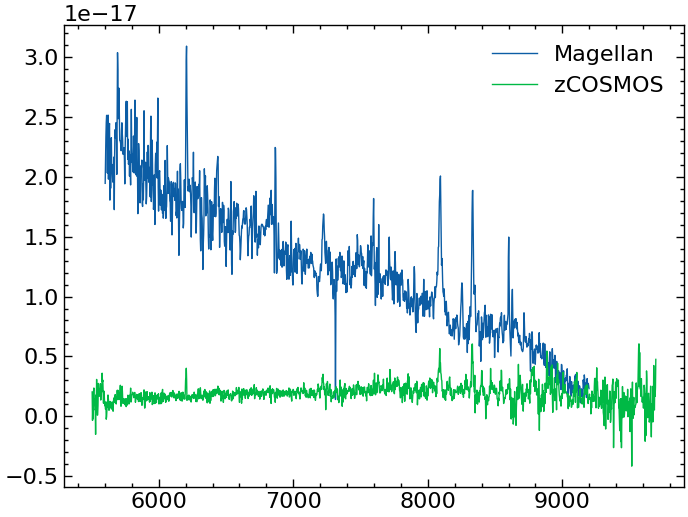

In [360]:
# SDSS J100252.84+021452.8 

hdu1 = fits.open('spec/magellan_opt_100252+021452_spec_31.fits')
data1 = hdu1[0].data
plt.plot(data1[0], data1[1], label='Magellan', linewidth=1)

hdu2 = fits.open('spec/zCOSMOS_BRIGHT_DR3_000821837_ZCMRa95_M1_Q2_16_1.fits')
data2 = hdu2[1].data
plt.plot(data2['WAVE'][0], data2['FLUX_REDUCED'][0], label='zCOSMOS', linewidth=1)

plt.legend()

hdu1[0].header['DATE-OBS'], hdu2[0].header['DATE-OBS']

SkyCoord(hdu1[0].header['RA']+' '+hdu1[0].header['DEC'], unit=(u.hourangle, u.deg)), \
SkyCoord(str(hdu2[0].header['RA'])+' '+str(hdu2[0].header['DEC']), unit=(u.deg, u.deg)), \
SkyCoord('10:02:52.84 +02:14:52.8', unit=(u.hourangle, u.deg)), 

(<SkyCoord (ICRS): (ra, dec) in deg
     (150.22791667, 1.67563889)>,
 <SkyCoord (ICRS): (ra, dec) in deg
     (150.612274, 1.99442)>,
 <SkyCoord (ICRS): (ra, dec) in deg
     (150.61225, 1.99447222)>)

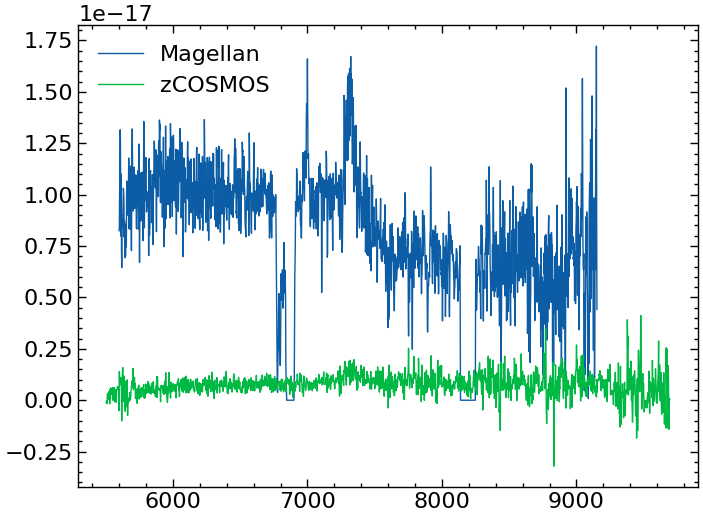

In [359]:
# ACS-GC 20054857

hdu1 = fits.open('spec/magellan_opt_100226+015940_spec_31.fits')
data1 = hdu1[0].data
plt.plot(data1[0], data1[1], label='Magellan', linewidth=1)

hdu2 = fits.open('spec/zCOSMOS_BRIGHT_DR3_000815962_ZCMRa83_M2_Q2_22_1.fits')
data2 = hdu2[1].data
plt.plot(data2['WAVE'][0], data2['FLUX_REDUCED'][0], label='zCOSMOS', linewidth=1)

plt.legend()

hdu1[0].header['DATE-OBS'], hdu2[0].header['DATE-OBS']

SkyCoord(hdu1[0].header['RA']+' '+hdu1[0].header['DEC'], unit=(u.hourangle, u.deg)), \
SkyCoord(str(hdu2[0].header['RA'])+' '+str(hdu2[0].header['DEC']), unit=(u.deg, u.deg)), \
SkyCoord('10h 02m 26.94s +01d 59m 40.1s')
# SkyCoord('10:02:52.84 +02:14:52.8', unit=(u.hourangle, u.deg)), 

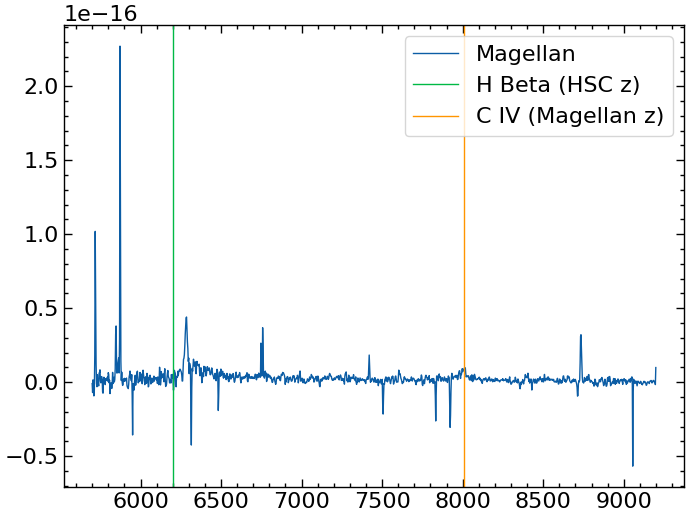

In [376]:
# COSMOS 2042408 (300)

hdu1 = fits.open('spec/magellan_opt_095906+022639_spec_31.fits')
data1 = hdu1[0].data
plt.plot(data1[0], data1[1], label='Magellan', linewidth=1)

# hdu2 = fits.open('spec/zCOSMOS_BRIGHT_DR3_000815962_ZCMRa83_M2_Q2_22_1.fits')
# data2 = hdu2[1].data
# plt.plot(data2['WAVE'][0], data2['FLUX_REDUCED'][0], label='zCOSMOS', linewidth=1)

wl_HB = 4861
wl_MgII = 2798
wl_CIV = 1549

z = 0.276
plt.axvline(x=wl_HB*(1+z), c='C1', linewidth=1, label='H Beta (HSC z)')

z = 4.17
plt.axvline(x=wl_CIV*(1+z), c='C2', linewidth=1, label='C IV (Magellan z)')

plt.legend(frameon=True)

In [ ]:
# COSMOS2015 382203 (52)






### Downloading instruciton

In [13]:
# Charlotte has already done SDSS - nice!

# Will add the other ones (XMM-spec, Caltech COSMOS Magellen etc,)

### HSC

data release: https://hsc-release.mtk.nao.ac.jp/doc/index.php/data-access__pdr3/

inquiry website: https://hsc-release.mtk.nao.ac.jp/datasearch/catalog_jobs

keyword description: https://hsc-release.mtk.nao.ac.jp/schema/#pdr3.pdr3_dud_rev.specz 

source catalog: 

```sql
-- Simple area search based on the range of RA and Dec getting all object
-- with i band Kron magnitudes smaller than 25.5, and in the area in
-- the range RA J2000 between 34.0 and 36.0 degrees and Dec J2000 -5.0
-- and -4.5 degrees.

-- WARNING:
--   --> Remove 'LIMIT 10' for your query
--   --> Edit the schema name 'pdr3_dud' for your query.

SELECT
    object_id
      , specz_ra
      , specz_dec
      , specz_redshift
      , specz_duplicationflag

      , specz_flag_zcosmos_bright_dr3
      , specz_flag_3dhst_v4_1_5
      , specz_flag_sdss_dr15
      , specz_flag_gama_dr3
      , specz_flag_udsz_dr1
      , specz_flag_vandels_dr2
      , specz_flag_c3r2_dr2
      , specz_flag_vvds_drfinal
      , specz_flag_deimos_2018
      , specz_flag_fmos_dr2
      , specz_flag_lega_c_dr2
      , specz_flag_primus_dr1
      , specz_flag_vipers_dr2
      , specz_flag_wigglez_dr1
      , specz_flag_deep23_dr4_egs

    FROM pdr3_dud_rev.specz
    WHERE
        specz_ra  BETWEEN 149.776 AND 149.777
        AND specz_dec BETWEEN 2.444   AND 2.445
    
;
```

For example, the target above is in `PRIMUS_DR1`. 